# Reporte de Fairness y Bias

Tomando en cuenta las implicaciones éticas, seleccionamos dos variables protegidas.
La primera es **originwac** que es la variable que agrupa los aeropuertos de origen por zonas geográficas en Estados Unidos. La variable es protegida porque no queremos que el modelo discrimine por la zone de provencia de los vuelos. Por ejemplo, de los vuelos de sur de Estados Unidos.
Adicionalmente, la segunda variable protegida es la **distancia** al ser una variable continua la dividiremos en quartiles para el análisis. El objetivo es que el modelo haga predicciones justas sin importar que el vuelo sea corto o largo.

En nuestro modelo intentamos predecir el retraso de un vuelo. Las consecuencias negativas de decir que un vuelo se va a retrasar y que no se retrase (falso positivo) son muchas más graves que decir que un vuelo no se va a retrasar y que se retrase (falso negativo). Es decir, que un usuario espere tiempo extra en el aeropuerto es menos grave que no llegué a su vuelo porque “pensó” que se iba a retrasar. Es por eso que nos interesan los falsos positivos más que los falsos negativos.

Como consecuencia, la métrica que nos interesa es **False Positive Parity** porque queremos que todas las zonas geográficas de Estados Unidos y grupos de distancia tengan el mismo FPR (false positive rate). Es decir, nos equivocamos en las mismas proporciones para etiquetas positivas que eran negativas.

Escogimos esta métrica ya que necesitamos que el modelo sea bueno detectando la etiqueta positiva y no hay (mucho) costo en introducir falsos negativos al sistema. El costo de un falso negativo es que usuarios esperen en el aeropuerto a su vuelo retrasado y este sería el status-quo sin el modelo o producto de datos. Asimismo, esta es la métrica adecuada porque  la variable target no es subjetiva. Si un vuelo se retrasa sabemos exactamente cuánto se retrasó y no depende de la persepción del usuario.


In [ ]:
!pip install psycopg2-binary
!pip install luigi
!pip install boto3
!pip install aequitas

In [2]:
import sys
sys.path.append('./../')

# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

#import src
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2


from src.train_model import run_model

import pandas as pd
import seaborn as sns
from aequitas.group import Group
from aequitas.bias import Bias
from aequitas.fairness import Fairness
from aequitas.plotting import Plot

import warnings; warnings.simplefilter('ignore')

%matplotlib inline

In [4]:
objetivo = "0-1.5"
model_name = "LR"
hyperparams = {"iter": 1,
              "pca": 1}
              
prediction, df_test = run_model(objetivo, model_name, hyperparams, luigi= False, test_split = 0.2)

(999, 61)
[Imputer_eb95f76d1fce, Imputer_400e5ad59545, VectorAssembler_7811a3181fd1, StandardScaler_f5a258323c1d]
Modelo evaluado:  LogisticRegression_782d887583e1 con params:  aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)
family: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)
featuresCol: features column name. (default: features)
fitIntercept: whether to fit an intercept term. (default: True)
labelCol: label column name. (default: label)
lowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for mu

In [15]:
vars_bias = ['prediction', 'originwac', 'label', 'distance']
df_bias = prediction.select([c for c in prediction.columns if c in vars_bias])

df_bias=df_bias.withColumnRenamed("prediction", "score").withColumnRenamed("label", "label_value")

In [16]:
df_bias.show()

+---------+--------+-----------+-----+
|originwac|distance|label_value|score|
+---------+--------+-----------+-----+
|     74.0|     190|        0.0|  1.0|
|     74.0|     190|        1.0|  1.0|
|     37.0|     862|        1.0|  1.0|
|     33.0|     993|        1.0|  1.0|
|     74.0|    1171|        1.0|  1.0|
|     33.0|    1045|        1.0|  1.0|
|     36.0|     650|        1.0|  1.0|
|     74.0|    1061|        1.0|  1.0|
|     91.0|    1171|        1.0|  1.0|
|     44.0|    1021|        1.0|  1.0|
|     74.0|     550|        1.0|  1.0|
|     74.0|     550|        1.0|  1.0|
|     74.0|     190|        1.0|  1.0|
|     91.0|    1744|        1.0|  1.0|
|     74.0|     190|        1.0|  1.0|
|     33.0|     993|        1.0|  1.0|
|     22.0|    1389|        1.0|  1.0|
|     91.0|    1846|        1.0|  1.0|
|     74.0|    1171|        1.0|  1.0|
|     33.0|     993|        1.0|  1.0|
+---------+--------+-----------+-----+
only showing top 20 rows



In [87]:
df_pandas = df_bias.toPandas()

In [88]:
df_pandas.head()

,originwac,distance,label_value,score
0,74.0,190,0.0,1.0
1,74.0,190,1.0,1.0
2,37.0,862,1.0,1.0
3,33.0,993,1.0,1.0
4,74.0,1171,1.0,1.0


In [89]:
import numpy as np #data aumentation (con poquitos datos no funciona)
df_pandas = df_pandas.append(df_pandas).append(df_pandas).append(df_pandas).append(df_pandas)
df_pandas['label_value'] = np.random.choice([0,1], df_pandas.shape[0])
df_pandas['score'] = np.random.choice([0,1], df_pandas.shape[0])

In [90]:
from aequitas.preprocessing import preprocess_input_df

df_pandas['originwac'] = df_pandas['originwac'].astype(str)
df_pandas['distance'] = df_pandas['distance'].astype(int)
df, _ = preprocess_input_df(df_pandas)

In [91]:
g = Group()
xtab, _ = g.get_crosstabs(df)

model_id, score_thresholds 1 {'rank_abs': [518]}


In [92]:
absolute_metrics = g.list_absolute_metrics(xtab)

In [93]:
xtab[[col for col in xtab.columns if col not in absolute_metrics]]

,model_id,score_threshold,k,attribute_name,attribute_value,pp,pn,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities
0,1,binary 0/1,518,originwac,11.0,16,14,4,8,6,12,20,10,30,1025
1,1,binary 0/1,518,originwac,22.0,45,40,25,17,23,20,37,48,85,1025
2,1,binary 0/1,518,originwac,3.0,36,34,18,19,15,18,37,33,70,1025
3,1,binary 0/1,518,originwac,33.0,83,82,40,36,46,43,79,86,165,1025
4,1,binary 0/1,518,originwac,36.0,40,45,18,24,21,22,46,39,85,1025
5,1,binary 0/1,518,originwac,37.0,22,13,13,10,3,9,19,16,35,1025
6,1,binary 0/1,518,originwac,38.0,10,5,4,0,5,6,6,9,15,1025
7,1,binary 0/1,518,originwac,41.0,2,8,1,1,7,1,2,8,10,1025
8,1,binary 0/1,518,originwac,44.0,20,20,8,14,6,12,26,14,40,1025
9,1,binary 0/1,518,originwac,72.0,14,6,6,2,4,8,10,10,20,1025


In [94]:
xtab[['attribute_name', 'attribute_value'] + absolute_metrics].round(2)

,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev
0,originwac,11.0,0.60,0.60,0.57,0.25,0.40,0.40,0.43,0.75,0.03,0.53,0.67
1,originwac,22.0,0.54,0.48,0.42,0.56,0.52,0.46,0.57,0.44,0.09,0.53,0.44
2,originwac,3.0,0.49,0.45,0.56,0.50,0.55,0.51,0.44,0.50,0.07,0.51,0.53
3,originwac,33.0,0.54,0.53,0.44,0.48,0.47,0.46,0.56,0.52,0.16,0.50,0.48
4,originwac,36.0,0.48,0.54,0.53,0.45,0.46,0.52,0.47,0.55,0.08,0.47,0.54
5,originwac,37.0,0.47,0.19,0.77,0.59,0.81,0.53,0.23,0.41,0.04,0.63,0.54
6,originwac,38.0,1.00,0.56,0.00,0.40,0.44,0.00,1.00,0.60,0.02,0.67,0.40
7,originwac,41.0,0.50,0.88,0.12,0.50,0.12,0.50,0.88,0.50,0.00,0.20,0.20
8,originwac,44.0,0.46,0.43,0.70,0.40,0.57,0.54,0.30,0.60,0.04,0.50,0.65
9,originwac,72.0,0.80,0.40,0.33,0.43,0.60,0.20,0.67,0.57,0.03,0.70,0.50


In [95]:
aqp = Plot()

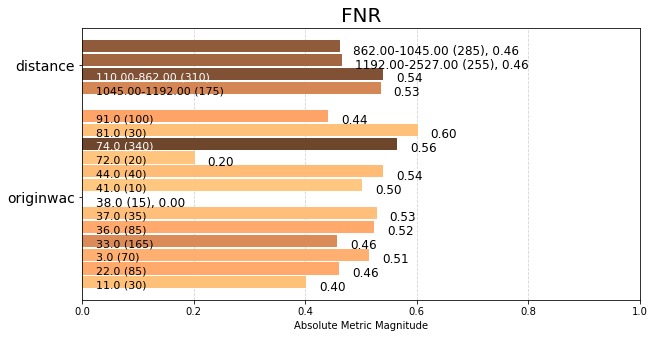

In [96]:
fnr = aqp.plot_group_metric(xtab, 'fnr')

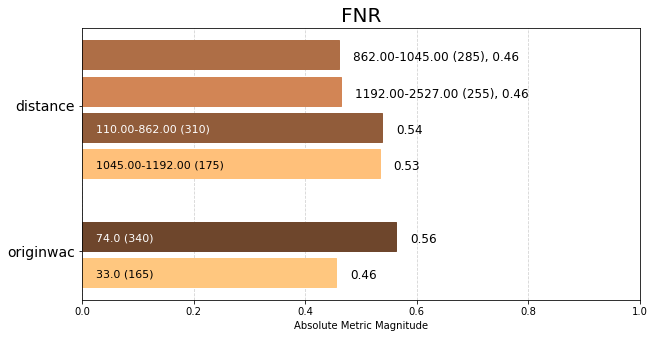

In [97]:
fnr = aqp.plot_group_metric(xtab, 'fnr', min_group_size=0.05)

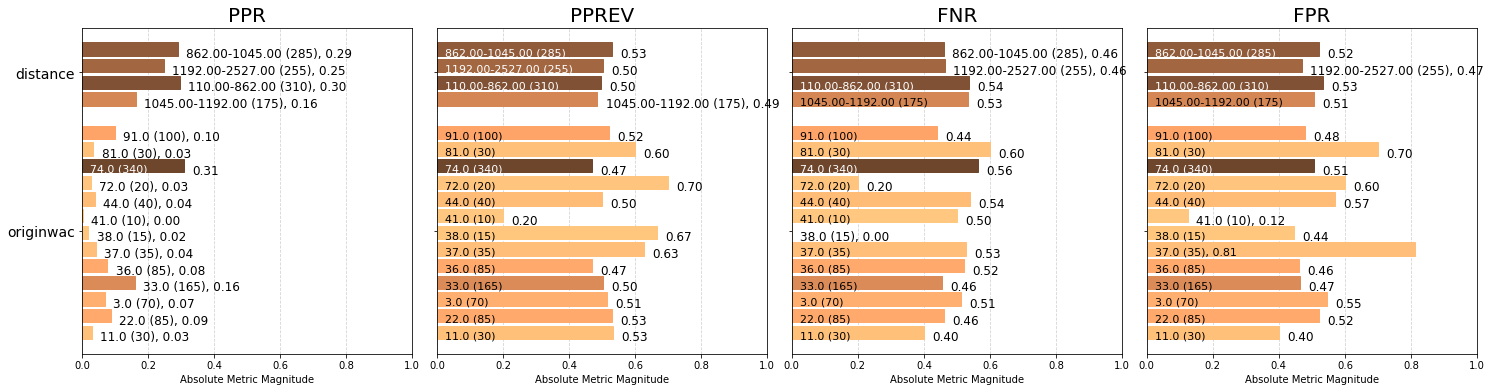

In [98]:
p = aqp.plot_group_metric_all(xtab, metrics=['ppr','pprev','fnr','fpr'], ncols=4)

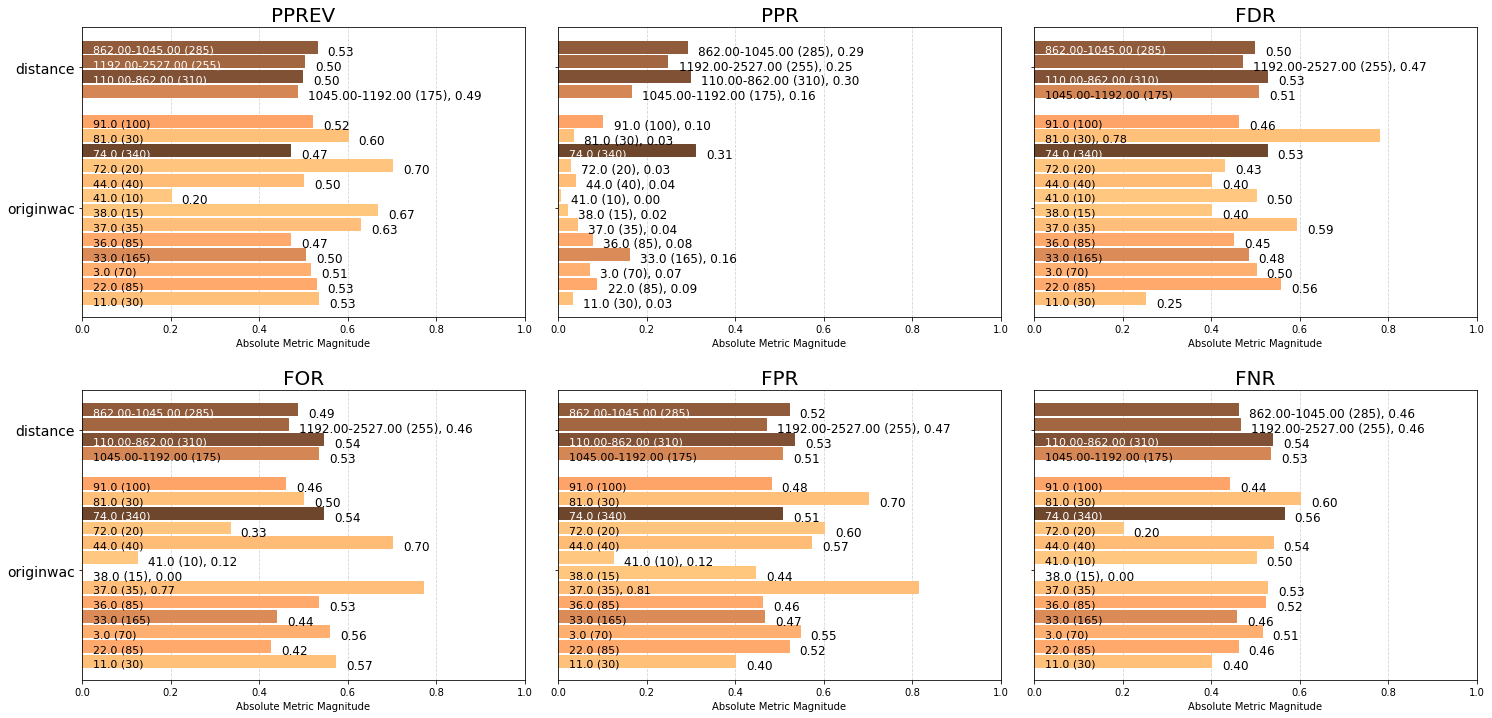

In [99]:
a = aqp.plot_group_metric_all(xtab, ncols=3)

In [100]:
b = Bias()

In [105]:
bdf = b.get_disparity_predefined_groups(xtab, original_df=df, ref_groups_dict={'originwac':'91.0','distance':'110.00-862.00' }, alpha=0.05, mask_significance=True)
bdf.style

get_disparity_predefined_group()


,model_id,score_threshold,k,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,pp,pn,ppr,pprev,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities,prev,ppr_disparity,pprev_disparity,precision_disparity,fdr_disparity,for_disparity,fpr_disparity,fnr_disparity,tpr_disparity,tnr_disparity,npv_disparity,ppr_ref_group_value,pprev_ref_group_value,precision_ref_group_value,fdr_ref_group_value,for_ref_group_value,fpr_ref_group_value,fnr_ref_group_value,tpr_ref_group_value,tnr_ref_group_value,npv_ref_group_value
0,1,binary 0/1,518,originwac,11.0,0.600000,0.600000,0.571429,0.250000,0.400000,0.400000,0.428571,0.750000,16,14,0.030888,0.533333,4,8,6,12,20,10,30,1025,0.666667,0.307692,1.025641,1.392857,0.541667,1.246753,0.833333,0.909091,1.071429,1.153846,0.791209,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0
1,1,binary 0/1,518,originwac,22.0,0.540541,0.479167,0.425000,0.555556,0.520833,0.459459,0.575000,0.444444,45,40,0.086873,0.529412,25,17,23,20,37,48,85,1025,0.435294,0.865385,1.018100,0.825397,1.203704,0.927273,1.085069,1.044226,0.965251,0.921474,1.061538,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0
2,1,binary 0/1,518,originwac,3.0,0.486486,0.454545,0.558824,0.500000,0.545455,0.513514,0.441176,0.500000,36,34,0.069498,0.514286,18,19,15,18,37,33,70,1025,0.528571,0.692308,0.989011,0.928571,1.083333,1.219251,1.136364,1.167076,0.868726,0.874126,0.814480,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0
3,1,binary 0/1,518,originwac,33.0,0.544304,0.534884,0.439024,0.481928,0.465116,0.455696,0.560976,0.518072,83,82,0.160232,0.503030,40,36,46,43,79,86,165,1025,0.478788,1.596154,0.967366,0.962134,1.044177,0.957871,0.968992,1.035673,0.971971,1.028623,1.035647,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0
4,1,binary 0/1,518,originwac,36.0,0.478261,0.538462,0.533333,0.450000,0.461538,0.521739,0.466667,0.550000,40,45,0.077220,0.470588,18,24,21,22,46,39,85,1025,0.541176,0.769231,0.904977,1.021429,0.975000,1.163636,0.961538,1.185771,0.854037,1.035503,0.861538,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0
5,1,binary 0/1,518,originwac,37.0,0.473684,0.187500,0.769231,0.590909,0.812500,0.526316,0.230769,0.409091,22,13,0.042471,0.628571,13,10,3,9,19,16,35,1025,0.542857,0.423077,1.208791,0.759740,1.280303,1.678322,1.692708,1.196172,0.845865,0.360577,0.426036,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0
6,1,binary 0/1,518,originwac,38.0,1.000000,0.555556,0.000000,0.400000,0.444444,0.000000,1.000000,0.600000,10,5,0.019305,0.666667,4,0,5,6,6,9,15,1025,0.400000,0.192308,1.282051,1.114286,0.866667,0.000000,0.925926,0.000000,1.785714,1.068376,1.846154,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0
7,1,binary 0/1,518,originwac,41.0,0.500000,0.875000,0.125000,0.500000,0.125000,0.500000,0.875000,0.500000,2,8,0.003861,0.200000,1,1,7,1,2,8,10,1025,0.200000,0.038462,0.384615,0.928571,1.083333,0.272727,0.260417,1.136364,0.892857,1.682692,1.615385,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0
8,1,binary 0/1,518,originwac,44.0,0.461538,0.428571,0.700000,0.400000,0.571429,0.538462,0.300000,0.600000,20,20,0.038610,0.500000,8,14,6,12,26,14,40,1025,0.650000,0.384615,0.961538,1.114286,0.866667,1.527273,1.190476,1.223776,0.824176,0.824176,0.553846,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0
9,1,binary 0/1,518,originwac,72.0,0.800000,0.400000,0.333333,0.428571,0.600000,0.200000,0.666667,0.571429,14,6,0.027027,0.700000,6,2,4,8,10,10,20,1025,0.500000,0.269231,1.346154,1.061224,0.928571,0.727273,1.250000,0.454545,1.428571,0.769231,1.230769,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0


In [106]:
calculated_disparities = b.list_disparities(bdf)
disparity_significance = b.list_significance(bdf)

In [107]:
disparity_significance

[]

In [108]:
# View disparity metrics added to dataframe
bdf[['attribute_name', 'attribute_value'] +  calculated_disparities + disparity_significance]

,attribute_name,attribute_value,ppr_disparity,pprev_disparity,precision_disparity,fdr_disparity,for_disparity,fpr_disparity,fnr_disparity,tpr_disparity,tnr_disparity,npv_disparity
0,originwac,11.0,0.307692,1.025641,1.392857,0.541667,1.246753,0.833333,0.909091,1.071429,1.153846,0.791209
1,originwac,22.0,0.865385,1.018100,0.825397,1.203704,0.927273,1.085069,1.044226,0.965251,0.921474,1.061538
2,originwac,3.0,0.692308,0.989011,0.928571,1.083333,1.219251,1.136364,1.167076,0.868726,0.874126,0.814480
3,originwac,33.0,1.596154,0.967366,0.962134,1.044177,0.957871,0.968992,1.035673,0.971971,1.028623,1.035647
4,originwac,36.0,0.769231,0.904977,1.021429,0.975000,1.163636,0.961538,1.185771,0.854037,1.035503,0.861538
5,originwac,37.0,0.423077,1.208791,0.759740,1.280303,1.678322,1.692708,1.196172,0.845865,0.360577,0.426036
6,originwac,38.0,0.192308,1.282051,1.114286,0.866667,0.000000,0.925926,0.000000,1.785714,1.068376,1.846154
7,originwac,41.0,0.038462,0.384615,0.928571,1.083333,0.272727,0.260417,1.136364,0.892857,1.682692,1.615385
8,originwac,44.0,0.384615,0.961538,1.114286,0.866667,1.527273,1.190476,1.223776,0.824176,0.824176,0.553846
9,originwac,72.0,0.269231,1.346154,1.061224,0.928571,0.727273,1.250000,0.454545,1.428571,0.769231,1.230769


In [110]:
hbdf = b.get_disparity_predefined_groups(xtab, original_df=df,
                                         ref_groups_dict={'originwac':'91.0','distance':'110.00-862.00' },
                                         alpha=0.05,
                                         mask_significance=False)

get_disparity_predefined_group()


In [111]:
# View disparity metrics added to dataframe
hbdf[['attribute_name', 'attribute_value'] +  calculated_disparities + disparity_significance]

,attribute_name,attribute_value,ppr_disparity,pprev_disparity,precision_disparity,fdr_disparity,for_disparity,fpr_disparity,fnr_disparity,tpr_disparity,tnr_disparity,npv_disparity
0,originwac,11.0,0.307692,1.025641,1.392857,0.541667,1.246753,0.833333,0.909091,1.071429,1.153846,0.791209
1,originwac,22.0,0.865385,1.018100,0.825397,1.203704,0.927273,1.085069,1.044226,0.965251,0.921474,1.061538
2,originwac,3.0,0.692308,0.989011,0.928571,1.083333,1.219251,1.136364,1.167076,0.868726,0.874126,0.814480
3,originwac,33.0,1.596154,0.967366,0.962134,1.044177,0.957871,0.968992,1.035673,0.971971,1.028623,1.035647
4,originwac,36.0,0.769231,0.904977,1.021429,0.975000,1.163636,0.961538,1.185771,0.854037,1.035503,0.861538
5,originwac,37.0,0.423077,1.208791,0.759740,1.280303,1.678322,1.692708,1.196172,0.845865,0.360577,0.426036
6,originwac,38.0,0.192308,1.282051,1.114286,0.866667,0.000000,0.925926,0.000000,1.785714,1.068376,1.846154
7,originwac,41.0,0.038462,0.384615,0.928571,1.083333,0.272727,0.260417,1.136364,0.892857,1.682692,1.615385
8,originwac,44.0,0.384615,0.961538,1.114286,0.866667,1.527273,1.190476,1.223776,0.824176,0.824176,0.553846
9,originwac,72.0,0.269231,1.346154,1.061224,0.928571,0.727273,1.250000,0.454545,1.428571,0.769231,1.230769


In [112]:
majority_bdf = b.get_disparity_major_group(xtab, original_df=df, mask_significance=True)

get_disparity_major_group()


In [113]:
majority_bdf[['attribute_name', 'attribute_value'] +  calculated_disparities + disparity_significance]

,attribute_name,attribute_value,ppr_disparity,pprev_disparity,precision_disparity,fdr_disparity,for_disparity,fpr_disparity,fnr_disparity,tpr_disparity,tnr_disparity,npv_disparity
0,originwac,11.0,0.100000,1.133333,1.578947,0.476190,1.049563,0.790476,0.710204,1.373684,1.214634,0.940767
1,originwac,22.0,0.281250,1.125000,0.935673,1.058201,0.780612,1.029266,0.815775,1.237553,0.970020,1.262195
2,originwac,3.0,0.225000,1.092857,1.052632,0.952381,1.026411,1.077922,0.911748,1.113798,0.920177,0.968436
3,originwac,33.0,0.518750,1.068939,1.090679,0.917958,0.806371,0.919158,0.809093,1.246169,1.082813,1.231410
4,originwac,36.0,0.250000,1.000000,1.157895,0.857143,0.979592,0.912088,0.926353,1.094966,1.090056,1.024390
5,originwac,37.0,0.137500,1.335714,0.861244,1.125541,1.412873,1.605655,0.934479,1.084488,0.379573,0.506567
6,originwac,38.0,0.062500,1.416667,1.263158,0.761905,0.000000,0.878307,0.000000,2.289474,1.124661,2.195122
7,originwac,41.0,0.012500,0.425000,1.052632,0.952381,0.229592,0.247024,0.887755,1.144737,1.771341,1.920732
8,originwac,44.0,0.125000,1.062500,1.263158,0.761905,1.285714,1.129252,0.956044,1.056680,0.867596,0.658537
9,originwac,72.0,0.087500,1.487500,1.203008,0.816327,0.612245,1.185714,0.355102,1.831579,0.809756,1.463415


In [114]:
min_metric_bdf = b.get_disparity_min_metric(df=xtab, original_df=df)

get_disparity_min_metric()


In [115]:
min_metric_bdf.style

,model_id,score_threshold,k,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,pp,pn,ppr,pprev,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities,prev,ppr_disparity,ppr_ref_group_value,pprev_disparity,pprev_ref_group_value,precision_disparity,precision_ref_group_value,fdr_disparity,fdr_ref_group_value,for_disparity,for_ref_group_value,fpr_disparity,fpr_ref_group_value,fnr_disparity,fnr_ref_group_value,tpr_disparity,tpr_ref_group_value,tnr_disparity,tnr_ref_group_value,npv_disparity,npv_ref_group_value
0,1,binary 0/1,518,originwac,11.0,0.600000,0.600000,0.571429,0.250000,0.400000,0.400000,0.428571,0.750000,16,14,0.030888,0.533333,4,8,6,12,20,10,30,1025,0.666667,8.000000,41.0,2.666667,41.0,3.375000,81.0,1.000000,11.0,10.000000,38.0,3.200000,41.0,10.000000,38.0,1.500000,81.0,3.200000,37.0,1.857143,37.0
1,1,binary 0/1,518,originwac,22.0,0.540541,0.479167,0.425000,0.555556,0.520833,0.459459,0.575000,0.444444,45,40,0.086873,0.529412,25,17,23,20,37,48,85,1025,0.435294,22.500000,41.0,2.647059,41.0,2.000000,81.0,2.222222,11.0,10.000000,38.0,4.166667,41.0,10.000000,38.0,1.351351,81.0,2.555556,37.0,2.491667,37.0
2,1,binary 0/1,518,originwac,3.0,0.486486,0.454545,0.558824,0.500000,0.545455,0.513514,0.441176,0.500000,36,34,0.069498,0.514286,18,19,15,18,37,33,70,1025,0.528571,18.000000,41.0,2.571429,41.0,2.250000,81.0,2.000000,11.0,10.000000,38.0,4.363636,41.0,10.000000,38.0,1.216216,81.0,2.424242,37.0,1.911765,37.0
3,1,binary 0/1,518,originwac,33.0,0.544304,0.534884,0.439024,0.481928,0.465116,0.455696,0.560976,0.518072,83,82,0.160232,0.503030,40,36,46,43,79,86,165,1025,0.478788,41.500000,41.0,2.515152,41.0,2.331325,81.0,1.927711,11.0,10.000000,38.0,3.720930,41.0,10.000000,38.0,1.360759,81.0,2.852713,37.0,2.430894,37.0
4,1,binary 0/1,518,originwac,36.0,0.478261,0.538462,0.533333,0.450000,0.461538,0.521739,0.466667,0.550000,40,45,0.077220,0.470588,18,24,21,22,46,39,85,1025,0.541176,20.000000,41.0,2.352941,41.0,2.475000,81.0,1.800000,11.0,10.000000,38.0,3.692308,41.0,10.000000,38.0,1.195652,81.0,2.871795,37.0,2.022222,37.0
5,1,binary 0/1,518,originwac,37.0,0.473684,0.187500,0.769231,0.590909,0.812500,0.526316,0.230769,0.409091,22,13,0.042471,0.628571,13,10,3,9,19,16,35,1025,0.542857,11.000000,41.0,3.142857,41.0,1.840909,81.0,2.363636,11.0,10.000000,38.0,6.500000,41.0,10.000000,38.0,1.184211,81.0,1.000000,37.0,1.000000,37.0
6,1,binary 0/1,518,originwac,38.0,1.000000,0.555556,0.000000,0.400000,0.444444,0.000000,1.000000,0.600000,10,5,0.019305,0.666667,4,0,5,6,6,9,15,1025,0.400000,5.000000,41.0,3.333333,41.0,2.700000,81.0,1.600000,11.0,nan,38.0,3.555556,41.0,nan,38.0,2.500000,81.0,2.962963,37.0,4.333333,37.0
7,1,binary 0/1,518,originwac,41.0,0.500000,0.875000,0.125000,0.500000,0.125000,0.500000,0.875000,0.500000,2,8,0.003861,0.200000,1,1,7,1,2,8,10,1025,0.200000,1.000000,41.0,1.000000,41.0,2.250000,81.0,2.000000,11.0,10.000000,38.0,1.000000,41.0,10.000000,38.0,1.250000,81.0,4.666667,37.0,3.791667,37.0
8,1,binary 0/1,518,originwac,44.0,0.461538,0.428571,0.700000,0.400000,0.571429,0.538462,0.300000,0.600000,20,20,0.038610,0.500000,8,14,6,12,26,14,40,1025,0.650000,10.000000,41.0,2.500000,41.0,2.700000,81.0,1.600000,11.0,10.000000,38.0,4.571429,41.0,10.000000,38.0,1.153846,81.0,2.285714,37.0,1.300000,37.0
9,1,binary 0/1,518,originwac,72.0,0.800000,0.400000,0.333333,0.428571,0.600000,0.200000,0.666667,0.571429,14,6,0.027027,0.700000,6,2,4,8,10,10,20,1025,0.500000,7.000000,41.0,3.500000,41.0,2.571429,81.0,1.714286,11.0,10.000000,38.0,4.800000,41.0,10.000000,38.0,2.000000,81.0,2.133333,37.0,2.888889,37.0


In [116]:
# View disparity metrics added to dataframe
min_metric_bdf[['attribute_name', 'attribute_value'] +  calculated_disparities + disparity_significance]

,attribute_name,attribute_value,ppr_disparity,pprev_disparity,precision_disparity,fdr_disparity,for_disparity,fpr_disparity,fnr_disparity,tpr_disparity,tnr_disparity,npv_disparity
0,originwac,11.0,8.000000,2.666667,3.375000,1.000000,10.000000,3.200000,10.000000,1.500000,3.200000,1.857143
1,originwac,22.0,22.500000,2.647059,2.000000,2.222222,10.000000,4.166667,10.000000,1.351351,2.555556,2.491667
2,originwac,3.0,18.000000,2.571429,2.250000,2.000000,10.000000,4.363636,10.000000,1.216216,2.424242,1.911765
3,originwac,33.0,41.500000,2.515152,2.331325,1.927711,10.000000,3.720930,10.000000,1.360759,2.852713,2.430894
4,originwac,36.0,20.000000,2.352941,2.475000,1.800000,10.000000,3.692308,10.000000,1.195652,2.871795,2.022222
5,originwac,37.0,11.000000,3.142857,1.840909,2.363636,10.000000,6.500000,10.000000,1.184211,1.000000,1.000000
6,originwac,38.0,5.000000,3.333333,2.700000,1.600000,NaN,3.555556,NaN,2.500000,2.962963,4.333333
7,originwac,41.0,1.000000,1.000000,2.250000,2.000000,10.000000,1.000000,10.000000,1.250000,4.666667,3.791667
8,originwac,44.0,10.000000,2.500000,2.700000,1.600000,10.000000,4.571429,10.000000,1.153846,2.285714,1.300000
9,originwac,72.0,7.000000,3.500000,2.571429,1.714286,10.000000,4.800000,10.000000,2.000000,2.133333,2.888889


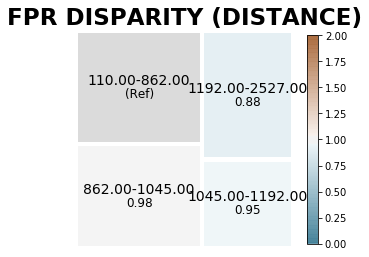

In [118]:
aqp.plot_disparity(bdf, group_metric='fpr_disparity', attribute_name='distance', significance_alpha=0.05)

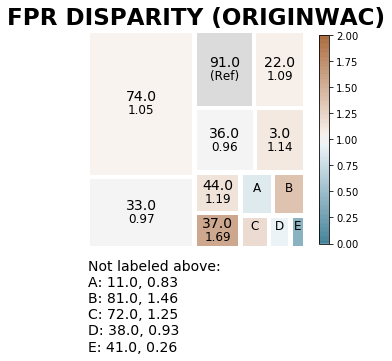

In [119]:
aqp.plot_disparity(hbdf, group_metric='fpr_disparity', attribute_name='originwac', significance_alpha=0.05)

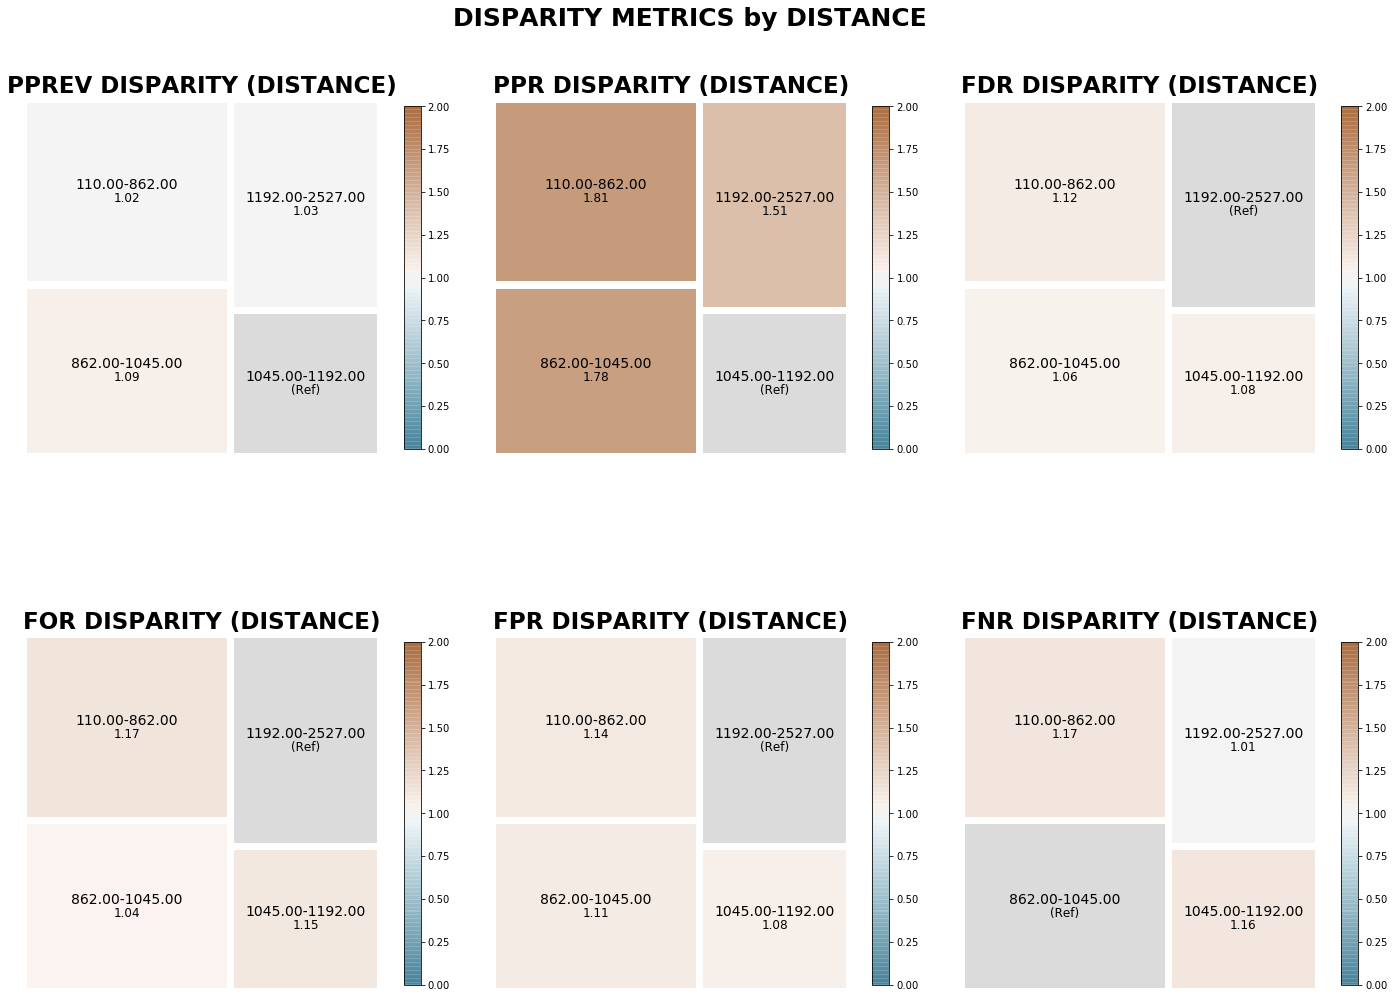

In [121]:
min_met = aqp.plot_disparity_all(min_metric_bdf, attributes=['distance'], significance_alpha=0.05)

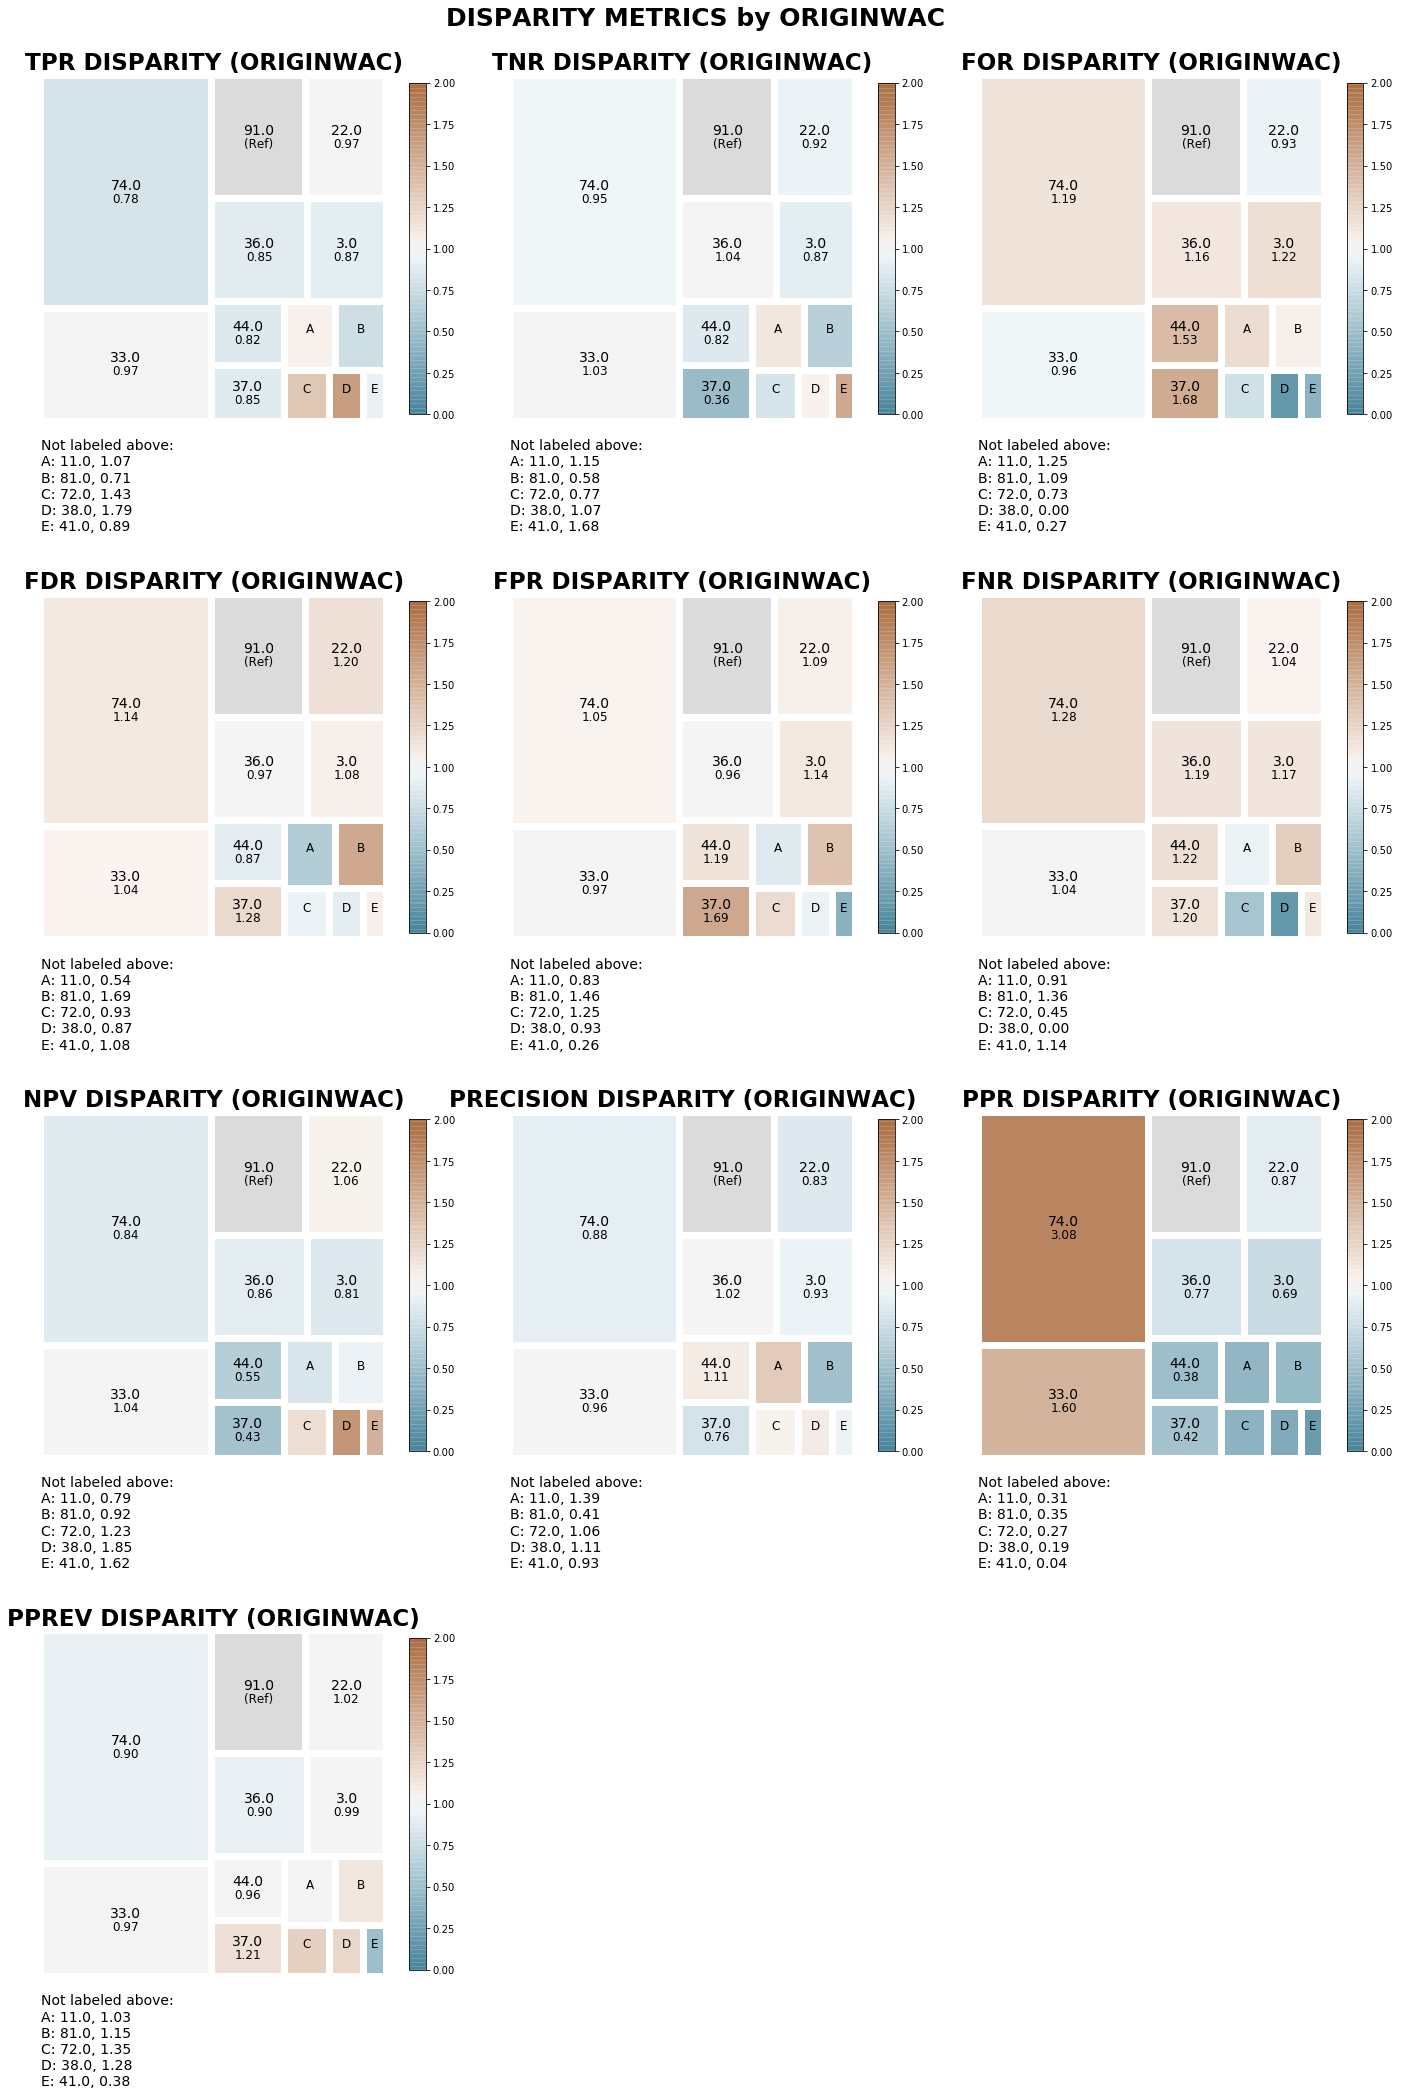

In [122]:
tm_capped = aqp.plot_disparity_all(hbdf, attributes=['originwac'], metrics = 'all', significance_alpha=0.05)

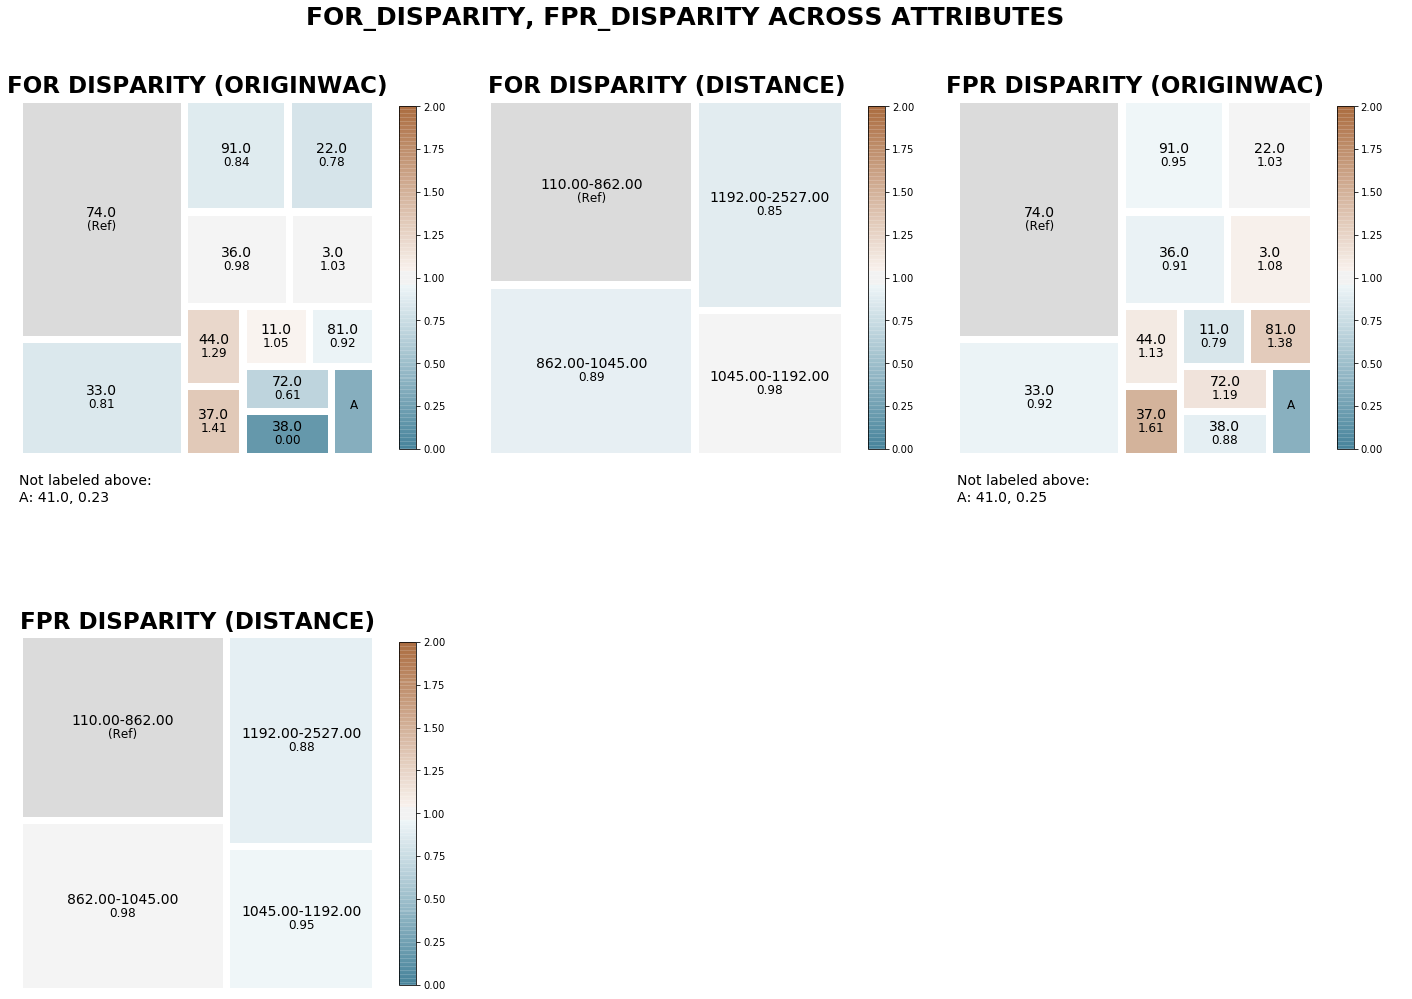

In [123]:
dp = aqp.plot_disparity_all(majority_bdf, metrics=['for_disparity', 'fpr_disparity'], significance_alpha=0.05)

In [124]:
f = Fairness()
fdf = f.get_group_value_fairness(bdf)

In [125]:
parity_detrminations = f.list_parities(fdf)

In [126]:
fdf[['attribute_name', 'attribute_value'] + absolute_metrics + calculated_disparities + parity_detrminations].style

,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev,ppr_disparity,pprev_disparity,precision_disparity,fdr_disparity,for_disparity,fpr_disparity,fnr_disparity,tpr_disparity,tnr_disparity,npv_disparity,FNR Parity,Precision Parity,Impact Parity,FOR Parity,Supervised Fairness,TypeI Parity,FDR Parity,FPR Parity,TPR Parity,NPV Parity,TNR Parity,Equalized Odds,Statistical Parity,Unsupervised Fairness,TypeII Parity
0,originwac,11.0,0.600000,0.600000,0.571429,0.250000,0.400000,0.400000,0.428571,0.750000,0.030888,0.533333,0.666667,0.307692,1.025641,1.392857,0.541667,1.246753,0.833333,0.909091,1.071429,1.153846,0.791209,True,False,True,True,False,False,False,True,True,False,True,True,False,False,True
1,originwac,22.0,0.540541,0.479167,0.425000,0.555556,0.520833,0.459459,0.575000,0.444444,0.086873,0.529412,0.435294,0.865385,1.018100,0.825397,1.203704,0.927273,1.085069,1.044226,0.965251,0.921474,1.061538,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
2,originwac,3.0,0.486486,0.454545,0.558824,0.500000,0.545455,0.513514,0.441176,0.500000,0.069498,0.514286,0.528571,0.692308,0.989011,0.928571,1.083333,1.219251,1.136364,1.167076,0.868726,0.874126,0.814480,True,True,True,True,True,True,True,True,True,True,True,True,False,False,True
3,originwac,33.0,0.544304,0.534884,0.439024,0.481928,0.465116,0.455696,0.560976,0.518072,0.160232,0.503030,0.478788,1.596154,0.967366,0.962134,1.044177,0.957871,0.968992,1.035673,0.971971,1.028623,1.035647,True,True,True,True,True,True,True,True,True,True,True,True,False,False,True
4,originwac,36.0,0.478261,0.538462,0.533333,0.450000,0.461538,0.521739,0.466667,0.550000,0.077220,0.470588,0.541176,0.769231,0.904977,1.021429,0.975000,1.163636,0.961538,1.185771,0.854037,1.035503,0.861538,True,True,True,True,True,True,True,True,True,True,True,True,False,False,True
5,originwac,37.0,0.473684,0.187500,0.769231,0.590909,0.812500,0.526316,0.230769,0.409091,0.042471,0.628571,0.542857,0.423077,1.208791,0.759740,1.280303,1.678322,1.692708,1.196172,0.845865,0.360577,0.426036,True,False,True,False,False,False,False,False,True,False,False,False,False,False,False
6,originwac,38.0,1.000000,0.555556,0.000000,0.400000,0.444444,0.000000,1.000000,0.600000,0.019305,0.666667,0.400000,0.192308,1.282051,1.114286,0.866667,0.000000,0.925926,0.000000,1.785714,1.068376,1.846154,False,True,False,False,False,True,True,True,False,False,True,False,False,False,False
7,originwac,41.0,0.500000,0.875000,0.125000,0.500000,0.125000,0.500000,0.875000,0.500000,0.003861,0.200000,0.200000,0.038462,0.384615,0.928571,1.083333,0.272727,0.260417,1.136364,0.892857,1.682692,1.615385,True,True,False,False,False,False,True,False,True,False,False,False,False,False,False
8,originwac,44.0,0.461538,0.428571,0.700000,0.400000,0.571429,0.538462,0.300000,0.600000,0.038610,0.500000,0.650000,0.384615,0.961538,1.114286,0.866667,1.527273,1.190476,1.223776,0.824176,0.824176,0.553846,True,True,True,False,False,True,True,True,True,False,True,True,False,False,False
9,originwac,72.0,0.800000,0.400000,0.333333,0.428571,0.600000,0.200000,0.666667,0.571429,0.027027,0.700000,0.500000,0.269231,1.346154,1.061224,0.928571,0.727273,1.250000,0.454545,1.428571,0.769231,1.230769,False,True,False,False,False,True,True,True,False,True,False,False,False,False,False


In [127]:
gaf = f.get_group_attribute_fairness(fdf)
gaf

,model_id,score_threshold,attribute_name,Statistical Parity,Impact Parity,FDR Parity,FPR Parity,FOR Parity,FNR Parity,TPR Parity,TNR Parity,NPV Parity,Precision Parity,TypeI Parity,TypeII Parity,Equalized Odds,Unsupervised Fairness,Supervised Fairness
0,1,binary 0/1,distance,False,True,True,True,True,True,True,True,True,True,True,True,True,False,True
1,1,binary 0/1,originwac,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [128]:
gof = f.get_overall_fairness(fdf)
gof

{'Unsupervised Fairness': False,
 'Supervised Fairness': False,
 'Overall Fairness': False}

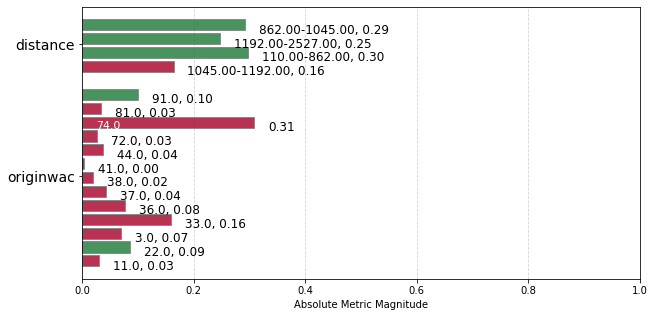

In [129]:
z = aqp.plot_fairness_group(fdf, group_metric='ppr')

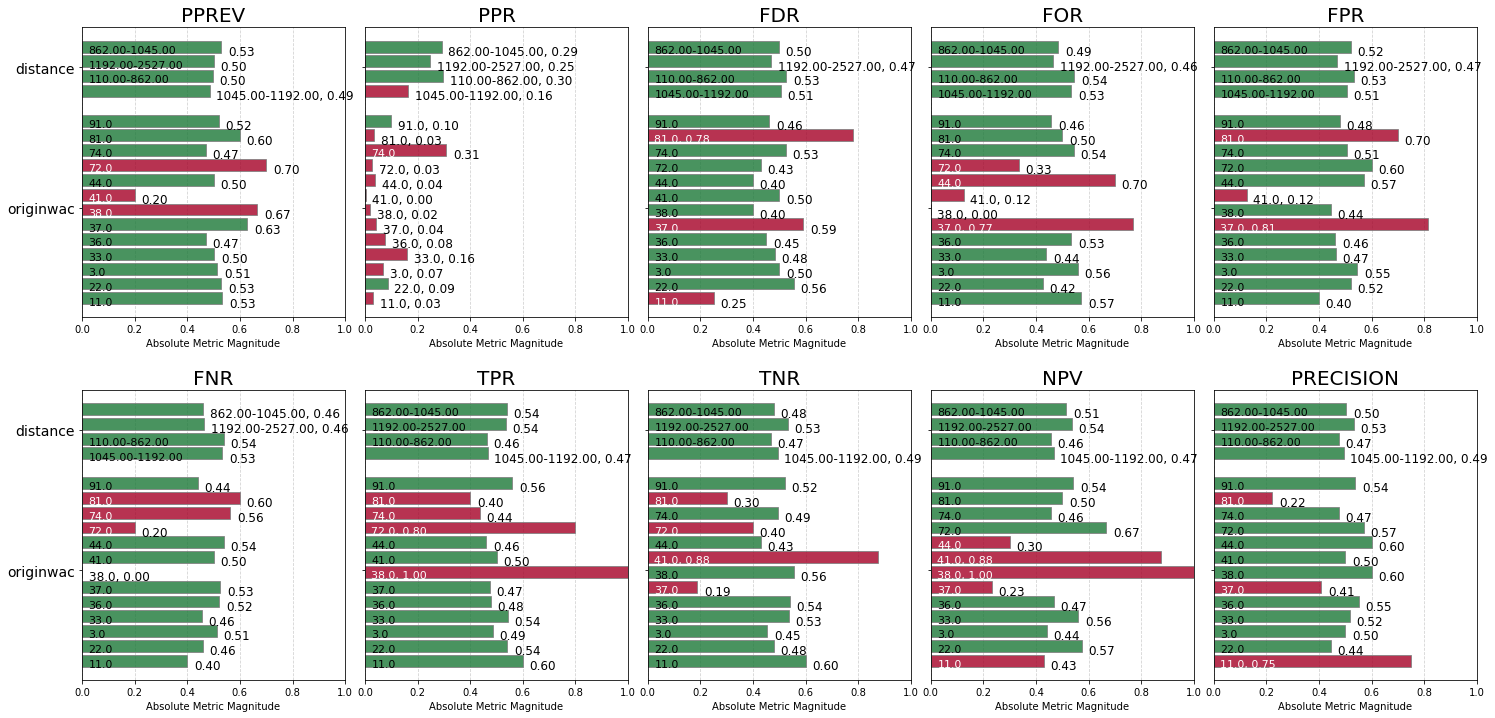

In [130]:
fg = aqp.plot_fairness_group_all(fdf, ncols=5, metrics = "all")

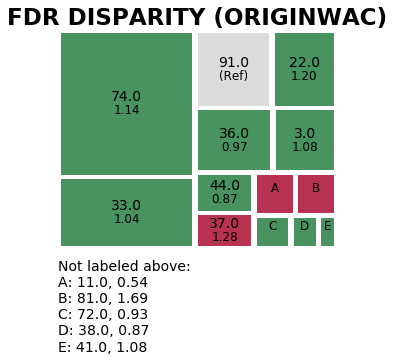

In [131]:
m = aqp.plot_fairness_disparity(fdf, group_metric='fdr', attribute_name='originwac')

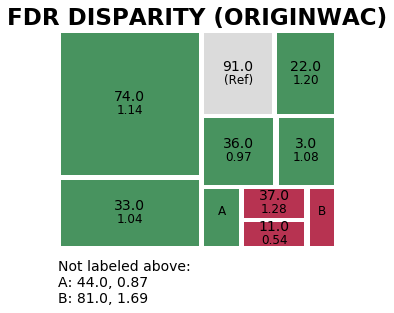

In [133]:
m = aqp.plot_fairness_disparity(fdf, group_metric='fdr', attribute_name='originwac',
                                min_group_size=0.01, significance_alpha=0.05)

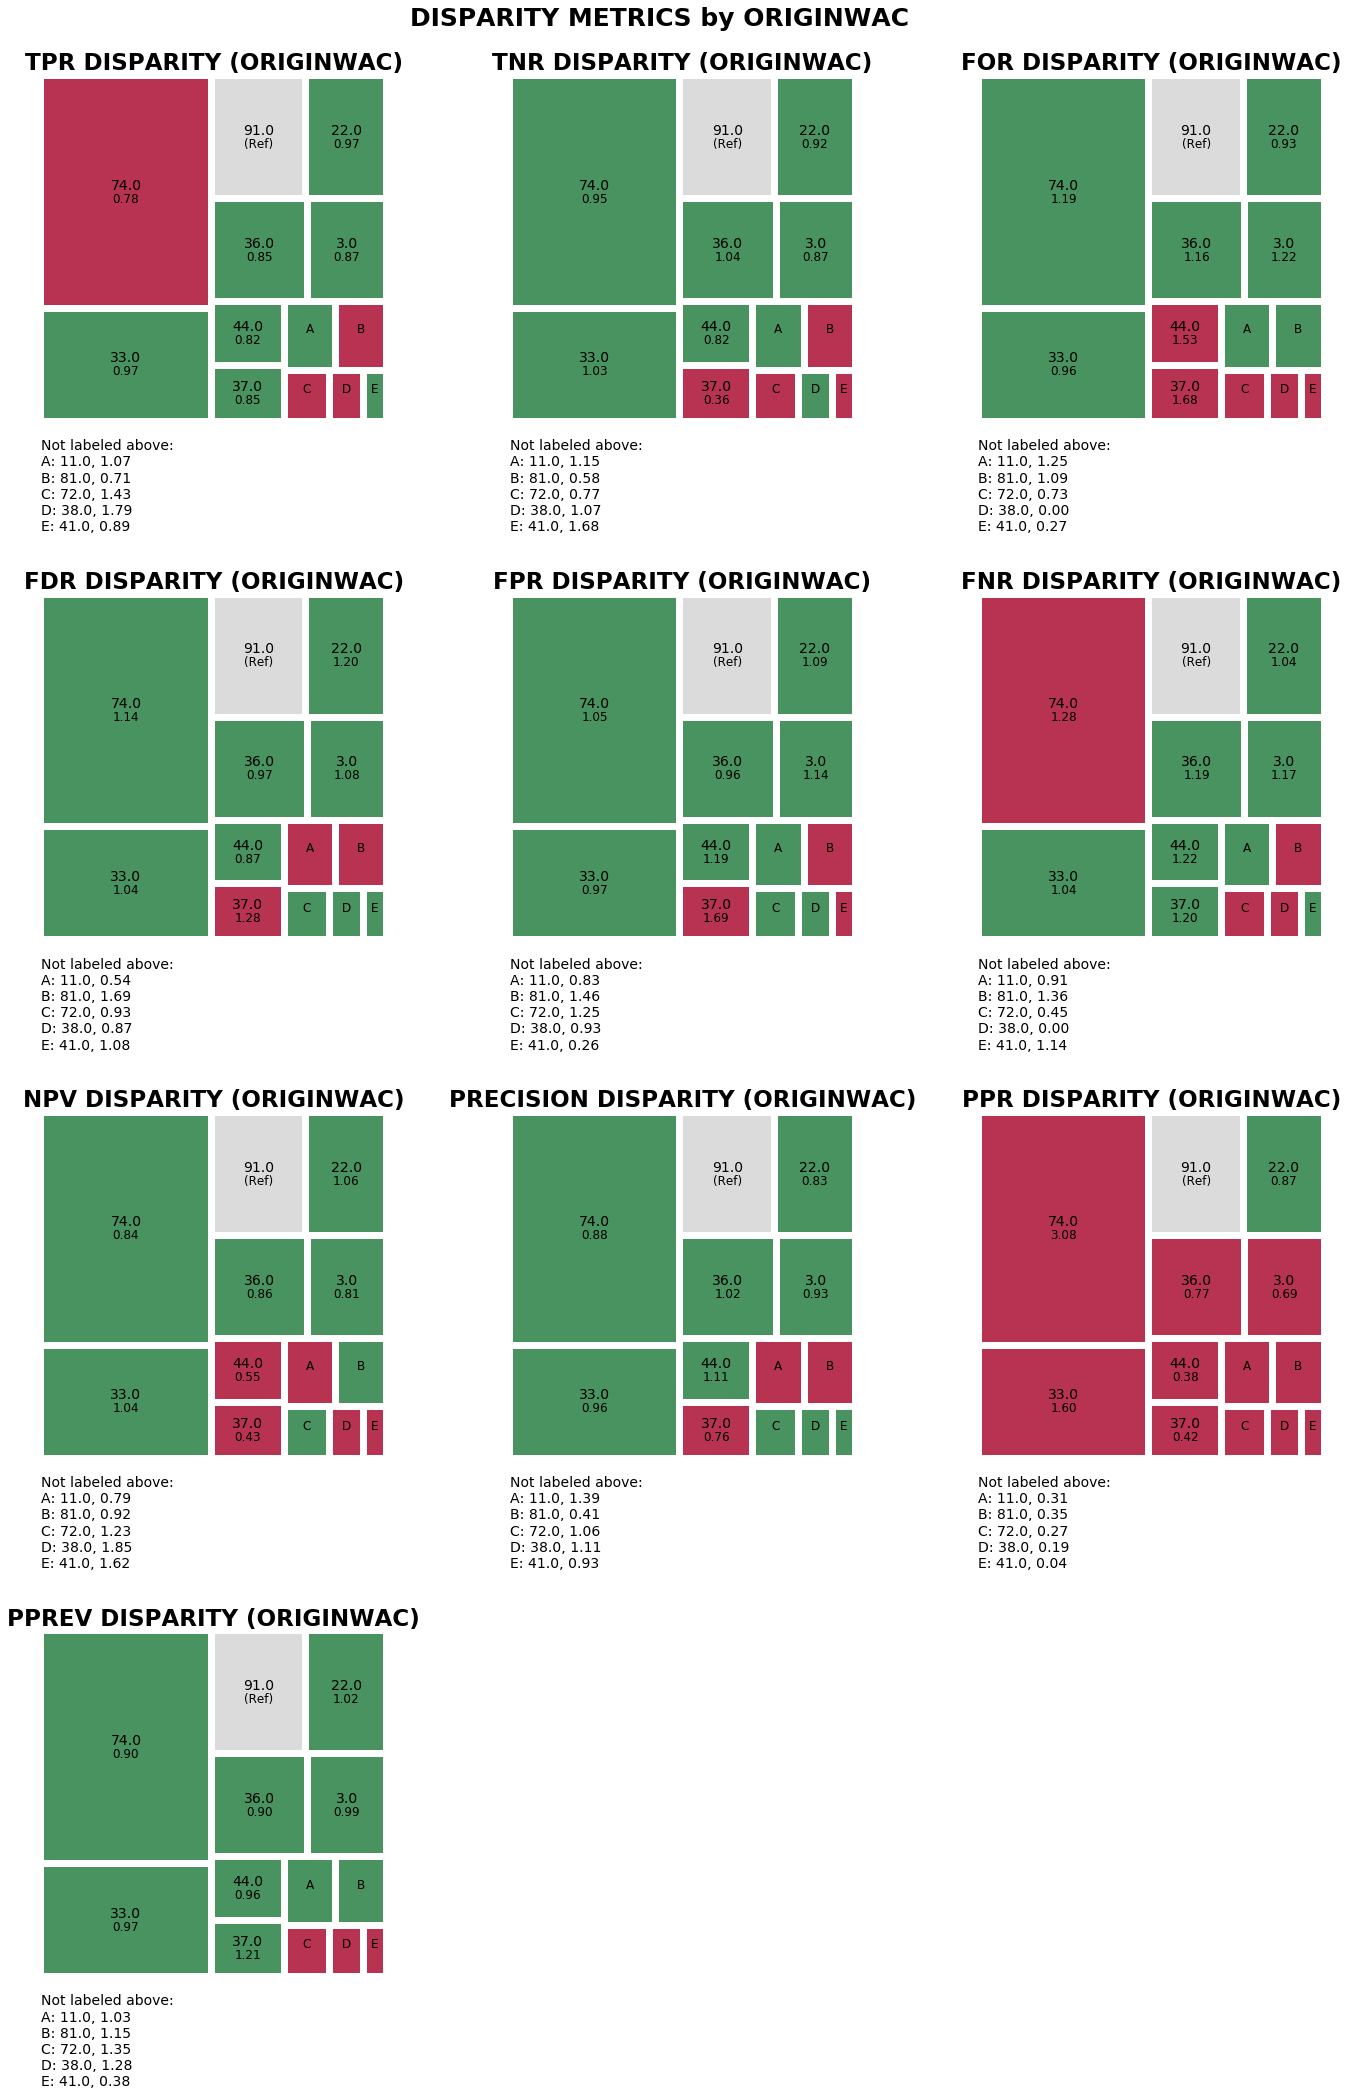

In [134]:
a_tm = aqp.plot_fairness_disparity_all(fdf, attributes=['originwac'], metrics='all',
                                       significance_alpha=0.05)

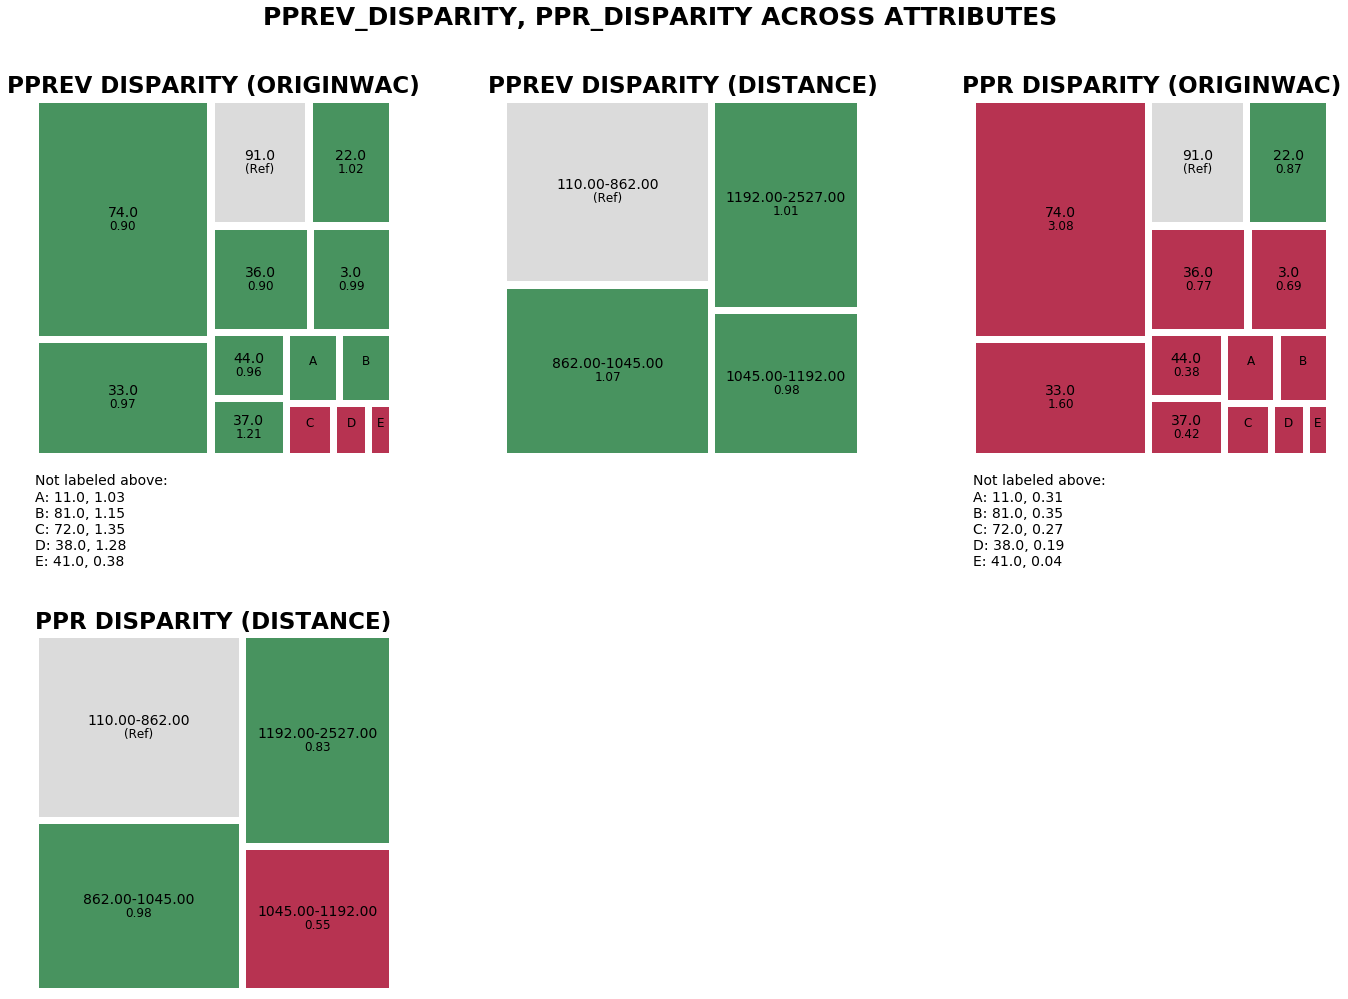

In [135]:
r_tm = aqp.plot_fairness_disparity_all(fdf, metrics=['pprev_disparity', 'ppr_disparity'],
                                       significance_alpha=0.05)

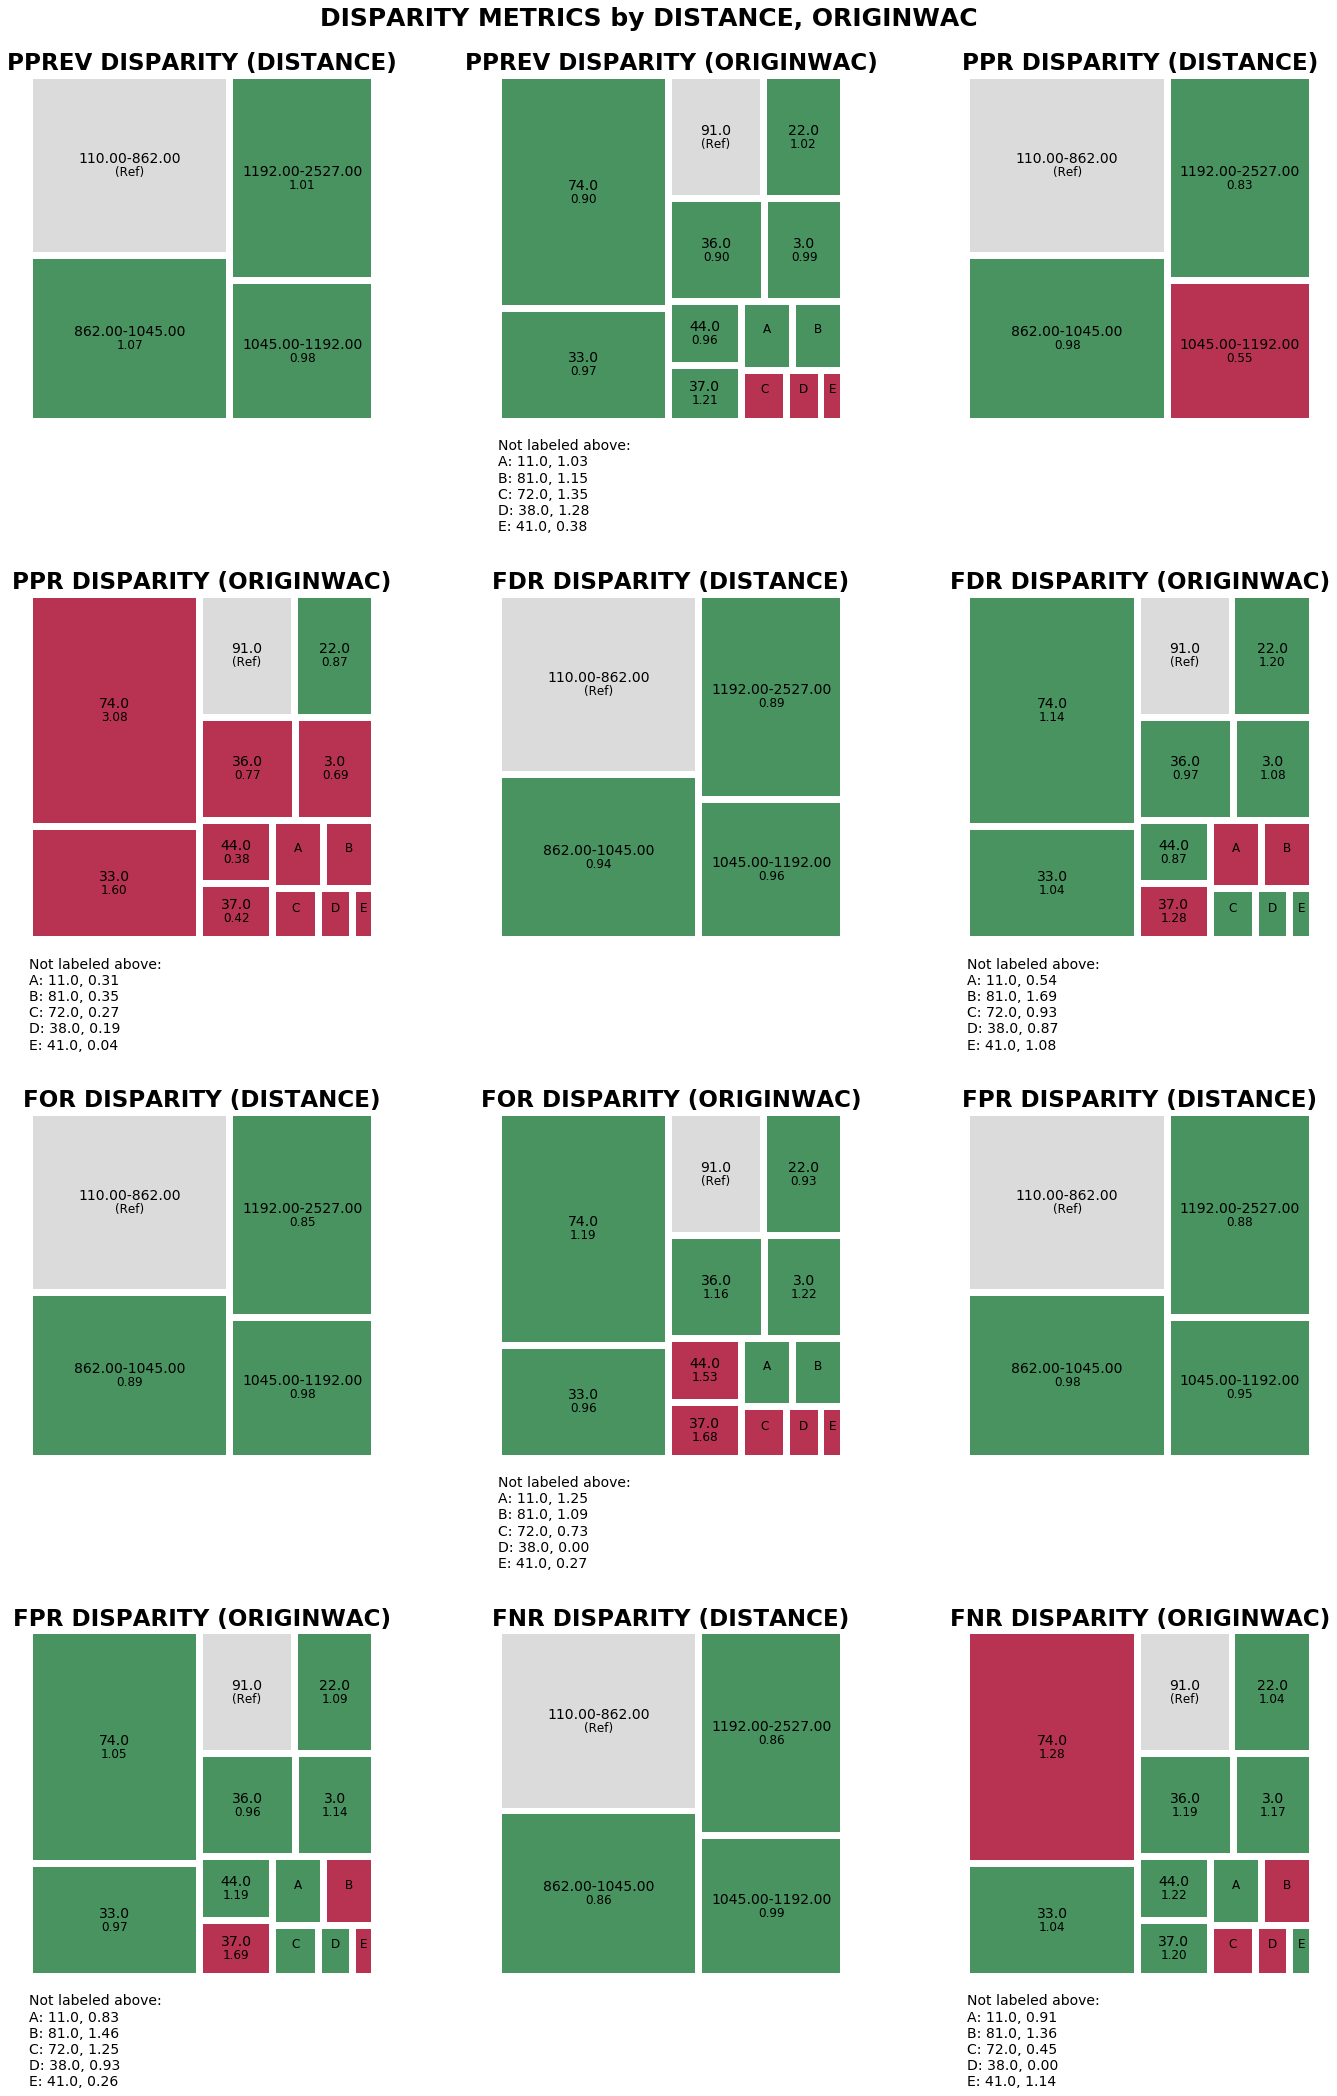

In [136]:
n_tm = aqp.plot_fairness_disparity_all(fdf, attributes=['distance', 'originwac'],
                                       significance_alpha=0.05)